In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import tensorflow as tf
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling3D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Lambda
from keras.layers import Reshape
from keras.layers import BatchNormalization
from keras.layers import GRU
from keras.layers import AveragePooling2D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras.optimizers as ops

In [0]:
#creation de la fonction qui va traiter les donnees
def reg_data(df):
    df = df.drop(df.index[[0,1,2]])
    df = df.drop('MW', axis=1)
    df.columns = ['Date', 'From', 'to', 'MW']
    
    dates = df['Date'].tolist()

    days = []
    months = []
    years = []
    for date in dates:
        days.append(date.split('.')[0])
        months.append(date.split('.')[1])
        years.append(date.split('.')[2])

    df['Day'] = days
    df['Month'] = months
    df['Year'] = years
    
    def fixMW(cols):
        TT = cols
        TT = TT.replace('.','')
        TT = TT.replace(',','.')
        return TT

    df['MW'] = df['MW'].apply(fixMW).astype(float)
    df['Day'] = df['Day'].astype(int)
    df['Month'] = df['Month'].astype(int)
    df['Year'] = df['Year'].astype(int)
    
    df = df.groupby(['Day','Month','Year'])['MW'].sum()
    df = pd.DataFrame(df)
    df['Month'] = df.index.get_level_values('Month') 
    df['Day'] = df.index.get_level_values('Day') 
    df['Year'] = df.index.get_level_values('Year') 
    df.reset_index(drop=True, inplace=True)
    return df
  
#appel de la fonction reg_data


Data_10 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2010.csv',sep=';')
Data_10 = reg_data(Data_10)

Data_11 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2011.csv',sep=';')
Data_11 = reg_data(Data_11)

Data_12 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2012.csv',sep=';')
Data_12 = reg_data(Data_12)

Data_13 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2013.csv',sep=';')
Data_13 = reg_data(Data_13)

Data_14 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2014.csv',sep=';')
Data_14 = reg_data(Data_14)
Data_15 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2015.csv',sep=';')
Data_15 = reg_data(Data_15)

Data_16 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2016.csv',sep=';')
Data_16 = reg_data(Data_16)

Data_17 = pd.read_csv('https://ws.50hertz.com/web02/api/PhotovoltaicActual/DownloadFile?fileName=2017.csv',sep=';')
Data_17 = reg_data(Data_17)





#concatener tout les donnees dans une seule DataFrame
DataFrame = pd.concat([ Data_10, Data_11, Data_12, Data_13,Data_14, Data_15, Data_16, Data_17], ignore_index=True)


In [0]:
DataFrame.head()

,MW,Month,Day,Year
0,16792.0,1,1,2014
1,43578.0,2,1,2014
2,101334.0,3,1,2014
3,105979.0,4,1,2014
4,98089.0,5,1,2014


In [0]:
#copier les donnees pour les conserver et travailler seulement avec la copie
model_data = DataFrame

In [0]:
#standarization des donnees
scaler = MinMaxScaler(feature_range=(0, 1))
model_data = scaler.fit_transform(model_data)

#creer une fonction qui va faire la fraction des donnees en Data_train and DataTest
def split_data(df):
    train_size = int(len(df) * 0.75)
    test_size = len(df) - train_size
    train, test = df[0:train_size,:], df[train_size:len(df),:]
    return train, test

#appel de la fonction "split data"
train, test = split_data(model_data)
print(len(model_data))
print(len(train))
print(len(test))

3468
2601
867


In [0]:
#creation de lafonction qui va fractionner les donnees Xtrain and Ytrain puis Xtest and Ytest
def Split_weekly(df, look_back=7):
	dataX, dataY = [], []
	for i in range(len(df)-look_back-1):
		a = df[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

#Appel de la fonction Split_weekly
Xtrain, Ytrain = Split_weekly(train)
Xtest, Ytest = Split_weekly(test)

print(len(Xtest))
print(len(Ytest))

print(len(Xtrain))
print(len(Ytrain))

859
859
2593
2593


In [0]:
#transformer la size des donnees en 3D
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

print(Xtest.shape[:])
print(Xtrain.shape[:])

model = Sequential()
model.add(GRU(units = 8, input_shape=(Xtrain.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units = 16))
model.add(Dropout(0.2))#drop out overfetting 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = ops.Nadam(lr=1e-3), loss = 'mse')


model_train = model.fit(Xtrain, Ytrain, validation_split=0.2, epochs=50, batch_size=8, verbose=1)

(859, 7, 1)
(2593, 7, 1)
Train on 2074 samples, validate on 519 samples
Epoch 1/50
2074/2074 [==============================] - 8s 4ms/step - loss: 0.0421 - val_loss: 0.0613
Epoch 2/50
2074/2074 [==============================] - 2s 1ms/step - loss: 0.0250 - val_loss: 0.0433
Epoch 3/50
2074/2074 [==============================] - 2s 1ms/step - loss: 0.0189 - val_loss: 0.0315
Epoch 4/50
2074/2074 [==============================] - 2s 1ms/step - loss: 0.0174 - val_loss: 0.0298
Epoch 5/50
2074/2074 [==============================] - 3s 1ms/step - loss: 0.0162 - val_loss: 0.0299
Epoch 6/50
2074/2074 [==============================] - 2s 1ms/step - loss: 0.0162 - val_loss: 0.0314
Epoch 7/50
2074/2074 [==============================] - 3s 1ms/step - loss: 0.0153 - val_loss: 0.0289
Epoch 8/50
2074/2074 [==============================] - 3s 1ms/step - loss: 0.0151 - val_loss: 0.0291
Epoch 9/50
2074/2074 [==============================] - 3s 1ms/step - loss: 0.0145 - val_loss: 0.0252
Epoch 10/5

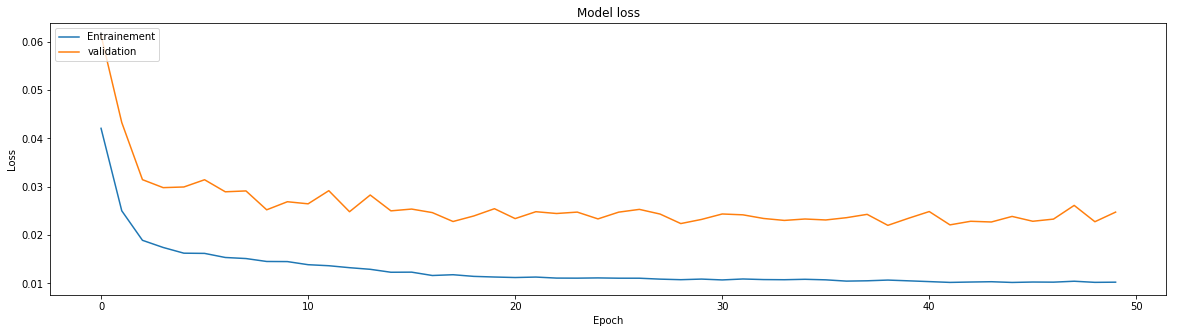

In [0]:
def ploter_Erreur(hist):
    f, axarr = plt.subplots(1,1, figsize=(20, 5))

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    axarr.set_title('Model loss')
    axarr.set_ylabel('Loss')
    axarr.set_xlabel('Epoch')
    axarr.legend(['Entrainement', 'validation'], loc='upper left')
    plt.show()
    
    
ploter_Erreur(model_train)

In [0]:
testPredict = model.predict(Xtest)

scaler2 = MinMaxScaler()
scaler2.min_, scaler2.scale_ = scaler.min_[0], scaler.scale_[0]

testPredict = scaler2.inverse_transform(testPredict)
Ytestp = scaler2.inverse_transform([Ytest])

mean_squared_error(Ytestp[0], testPredict[:,0])


0.07000850699697066